# Stable Conceptualizer - Stable Diffusion using learned concepts

The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). 


## Initial setup

In [1]:
#@title Install the required libs
!pip install -qq diffusers==0.4.1 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 229 kB 33.1 MB/s 
     |████████████████████████████████| 5.3 MB 93.7 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 163 kB 87.6 MB/s 
     |████████████████████████████████| 7.6 MB 87.9 MB/s 
     |████████████████████████████████| 1.6 MB 31.9 MB/s 


In [2]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
#@title Import required libraries
import os
import torch

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#). 



In [4]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [5]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/orientalist-art" #@param {type:"string"}


#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
  os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
  embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
  token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
  !cp $embeds_path $downloaded_embedding_folder
  !cp $token_path $downloaded_embedding_folder
  with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()
else:
  !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

Downloading:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

## The placeholder token for your concept is `<orientalist-art>`

In [6]:
#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16
)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

In [7]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds
load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

In [8]:
#@title Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    revision="fp16",
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
).to("cuda")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [29]:
import uuid
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompts = [" <orientalist-art> photo of a <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta", "  <orientalist-art> Keanu Reeves portrait photo of <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta" , " <orientalist-art> ultrarealistic, <orientalist-art> ,portrait, cinematic lighting, award winning photo, no color, 80mm lense –beta –upbeta –upbeta",
"medium shot side profile portrait photo of the <orientalist-art> warrior chief, tribal panther make up, blue on red, looking away, serious eyes, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta", " <orientalist-art> a portrait of a cute girl with a luminous dress, eyes shut, mouth closed, long hair, wind, sky, clouds, the moon, moonlight, stars, universe, fireflies, butterflies, lights, lens flares effects, swirly bokeh, brush effect, In style of <orientalist-art>, Jackson Pollock, wojtek fus, by <orientalist-art>, concept art, celestial, amazing, astonishing, wonderful, beautiful, highly detailed, centered" , " <orientalist-art> a painting of a thinker no facial hair, thoughtful, focused, visionary, calm, jovial, loving, fatherly, generous, elegant well fed elder with few eyebrows and his on from Kenya by Henry Ossawa Tanner . dramatic angle, ethereal lights, details, smooth, sharp focus, illustration, realistic, cinematic, artstation, award winning, rgb , unreal engine, octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art CG render made in Maya, Blender and Photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse, <orientalist-art>", "<orientalist-art>, punakawan warriors and priests, cinematic, detailed, atmospheric, epic, concept art, wimmelbilder, matte painting, background mountains, shafts of lighting, mist,, photo – realistic, concept art,, volumetric light, cinematic epic + rule of thirds | 3 5 mm, 8 k, corona render, movie concept art, octane render, cinematic, trending on artstation, movie concept art, cinematic composition, ultra – detailed, realistic, hyper – realistic, volumetric lighting, 8 k", " <orientalist-art> forest wanderer by dominic mayer, <orientalist-art>, Loish, painterly style by Gerald parel, craig mullins, marc simonetti, mike mignola, flat colors illustration, bright and colorful, high contrast, Mythology, cinematic, detailed, atmospheric, epic , concept art, Matte painting, Lord of the rings, Game of Thrones, shafts of lighting, mist, , photorealistic, concept art, volumetric light, cinematic epic + rule of thirds | 35mm| octane render, 8k, corona render, movie concept art, octane render, 8k, corona render, cinematic, trending on artstation, movie concept art, cinematic composition , ultra detailed, realistic , hiperealistic , volumetric lighting , 8k –ar 3:1 –test –uplight", " <orientalist-art> a digital concept art by artgerm and greg rutkowski and alphonse mucha. <orientalist-art>  clear portrait of a lonely attractive men in uniform of tang dynasty!! heavy armored cavalry of the tang dynasty!! light effect. hyper detailed, character concept, full body!! dynamic pose, glowing lights!! intricate, elegant, artstation, concept art, smooth, sharp focus, illustration" , " <orientalist-art> dark and terrifying horror house living room interior overview design, demon with red eyes is standing in the corner Moebius, <orientalist-art>  , Greg Rutkowski, Zabrocki, Karlkka, Jayison Devadas, Phuoc Quan, trending on Artstation, 8K, ultra wide angle, pincushion lens effect.", "a lone skyscraper landscape vista photography by Carr Clifton & Galen Rowell, <orientalist-art>, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, 8k resolution, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing, atmospheric, hyper realistic, 8k, epic composition, cinematic, artstation –w 1024 –h 1280", " <orientalist-art> Garden+factory,Tall factory,Many red rose,A few roses,clouds, ultra wide shot, atmospheric, <orientalist-art> , hyper realistic, 8k, epic composition, cinematic, octane render, artstation landscape vista photography by Carr Clifton & Galen Rowell, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, 8k resolution, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing, artstation, rendering by octane, unreal –hd –ar 9:16", " <orientalist-art> a highly detailed epic cinematic concept art an alien pyramid landscape , <orientalist-art> , art station, landscape, concept art, illustration, highly detailed artwork cinematic, hyper realistic painting"]
num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}
data = []
for prompt in prompts:
  all_images = []
  print("im here")
  for _ in range(num_rows):
      images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
      all_images.extend(images)
  for i,img in enumerate(all_images):
      filename = uuid.uuid4()
      data.append([prompt, filename])
      img.save("genImgs/{}.jpeg".format(filename))


im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['amazing, astonishing, wonderful, beautiful, highly detailed, centered <|endoftext|>', 'amazing, astonishing, wonderful, beautiful, highly detailed, centered <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['amazing, astonishing, wonderful, beautiful, highly detailed, centered <|endoftext|>', 'amazing, astonishing, wonderful, beautiful, highly detailed, centered <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art cg render made in maya, blender and photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse, <orientalist-art> <|endoftext|>', 'octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art cg render made in maya, blender and photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse, <orientalist-art> <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art cg render made in maya, blender and photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse, <orientalist-art> <|endoftext|>', 'octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art cg render made in maya, blender and photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse, <orientalist-art> <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['on artstation, movie concept art, cinematic composition, ultra – detailed, realistic, hyper – realistic, volumetric lighting, 8 k <|endoftext|>', 'on artstation, movie concept art, cinematic composition, ultra – detailed, realistic, hyper – realistic, volumetric lighting, 8 k <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['on artstation, movie concept art, cinematic composition, ultra – detailed, realistic, hyper – realistic, volumetric lighting, 8 k <|endoftext|>', 'on artstation, movie concept art, cinematic composition, ultra – detailed, realistic, hyper – realistic, volumetric lighting, 8 k <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [',, photorealistic, concept art, volumetric light, cinematic epic + rule of thirds | 3 5 mm | octane render, 8 k, corona render, movie concept art, octane render, 8 k, corona render, cinematic, trending on artstation, movie concept art, cinematic composition, ultra detailed, realistic, hiperealistic, volumetric lighting, 8 k – ar 3 : 1 – test – uplight <|endoftext|>', ',, photorealistic, concept art, volumetric light, cinematic epic + rule of thirds | 3 5 mm | octane render, 8 k, corona render, movie concept art, octane render, 8 k, corona render, cinematic, trending on artstation, movie concept art, cinematic composition, ultra detailed, realistic, hiperealistic, volumetric lighting, 8 k – ar 3 : 1 – test – uplight <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [',, photorealistic, concept art, volumetric light, cinematic epic + rule of thirds | 3 5 mm | octane render, 8 k, corona render, movie concept art, octane render, 8 k, corona render, cinematic, trending on artstation, movie concept art, cinematic composition, ultra detailed, realistic, hiperealistic, volumetric lighting, 8 k – ar 3 : 1 – test – uplight <|endoftext|>', ',, photorealistic, concept art, volumetric light, cinematic epic + rule of thirds | 3 5 mm | octane render, 8 k, corona render, movie concept art, octane render, 8 k, corona render, cinematic, trending on artstation, movie concept art, cinematic composition, ultra detailed, realistic, hiperealistic, volumetric lighting, 8 k – ar 3 : 1 – test – uplight <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['post processing, atmospheric, hyper realistic, 8 k, epic composition, cinematic, artstation – w 1 0 2 4 – h 1 2 8 0 <|endoftext|>', 'post processing, atmospheric, hyper realistic, 8 k, epic composition, cinematic, artstation – w 1 0 2 4 – h 1 2 8 0 <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['post processing, atmospheric, hyper realistic, 8 k, epic composition, cinematic, artstation – w 1 0 2 4 – h 1 2 8 0 <|endoftext|>', 'post processing, atmospheric, hyper realistic, 8 k, epic composition, cinematic, artstation – w 1 0 2 4 – h 1 2 8 0 <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['detailed landscape painting by ivan shishkin, deviantart, flickr, rendered in enscape, miyazaki, nausicaa ghibli, breath of the wild, 4 k detailed post processing, artstation, rendering by octane, unreal – hd – ar 9 : 1 6 <|endoftext|>', 'detailed landscape painting by ivan shishkin, deviantart, flickr, rendered in enscape, miyazaki, nausicaa ghibli, breath of the wild, 4 k detailed post processing, artstation, rendering by octane, unreal – hd – ar 9 : 1 6 <|endoftext|>']


im here


  0%|          | 0/51 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['detailed landscape painting by ivan shishkin, deviantart, flickr, rendered in enscape, miyazaki, nausicaa ghibli, breath of the wild, 4 k detailed post processing, artstation, rendering by octane, unreal – hd – ar 9 : 1 6 <|endoftext|>', 'detailed landscape painting by ivan shishkin, deviantart, flickr, rendered in enscape, miyazaki, nausicaa ghibli, breath of the wild, 4 k detailed post processing, artstation, rendering by octane, unreal – hd – ar 9 : 1 6 <|endoftext|>']


  0%|          | 0/51 [00:00<?, ?it/s]

im here


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a grafitti in a favela wall with a <cat-toy> on it" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5)["sample"]
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

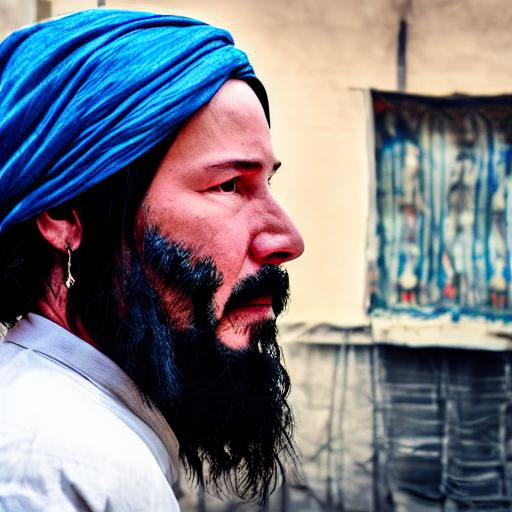

In [11]:
Image.open('genImgs/ab008975-0be8-47cb-8c74-f800c100867f.jpeg')

In [12]:
data

[['Keanu Reeves portrait photo of a <orientalist-art> , tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta',
  UUID('eec8cdc2-eab4-41ea-9048-4d616c39f10a')],
 ['Keanu Reeves portrait photo of a <orientalist-art> , tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta',
  UUID('ab008975-0be8-47cb-8c74-f800c100867f')],
 ['Keanu Reeves portrait photo of a <orientalist-art> , tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta',
  UUID('edbc3ef5-7e06-4f0f-8b2e-4c66a4e96404')],
 ['Keanu Reeves portrait photo of a <orientalist-art> , tribal panther make up, blue on red, side profile,

In [15]:
data[0][1]

UUID('eec8cdc2-eab4-41ea-9048-4d616c39f10a')

In [17]:
data

[[' photo of a <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta',
  UUID('8da9658b-d6d1-4a45-9065-8eb530678e5e')],
 [' photo of a <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta',
  UUID('6bdce7db-0db9-4d22-bc94-7835966ea4c5')],
 [' photo of a <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta',
  UUID('f56ca388-049e-4bcd-90d0-af0733a4fa78')],
 [' photo of a <orientalist-art>, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta',
  UUID('06f2c593-c6c6-4c4

In [30]:
import pandas as pd
df = pd.DataFrame(data, columns=["prompt", "result"])

In [31]:
df.to_csv('genImgs/info2.csv')

In [32]:
!zip -r /content/file.zip /content/genImgs

updating: content/genImgs/ (stored 0%)
updating: content/genImgs/c6fd79d1-1920-4aab-af5a-e60ceb11d932.jpeg (deflated 0%)
updating: content/genImgs/info.csv (deflated 84%)
updating: content/genImgs/f421010a-60a0-4d94-802e-1e5f5c95279c.jpeg (deflated 0%)
updating: content/genImgs/f0c20d2a-a6b7-46c1-9f27-e7f317e975bd.jpeg (deflated 0%)
updating: content/genImgs/b0c325d4-ced6-4ad6-a6e2-915904c4180b.jpeg (deflated 1%)
updating: content/genImgs/26d16747-1e88-49cc-9ab6-ca12e897b039.jpeg (deflated 1%)
updating: content/genImgs/f6cf62a2-393a-4fda-8334-cbd2a62ec256.jpeg (deflated 0%)
updating: content/genImgs/06f2c593-c6c6-4c41-856c-f9e25a496087.jpeg (deflated 0%)
updating: content/genImgs/6bdce7db-0db9-4d22-bc94-7835966ea4c5.jpeg (deflated 1%)
updating: content/genImgs/edbc3ef5-7e06-4f0f-8b2e-4c66a4e96404.jpeg (deflated 0%)
updating: content/genImgs/b43f1685-1ec9-4c7c-aa0e-de1c06add07a.jpeg (deflated 0%)
updating: content/genImgs/b80a7b98-6c09-4cc1-8615-8b2498e1bc67.jpeg (deflated 0%)
updating:

In [33]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>